In [114]:
import numpy as np

import matplotlib.pyplot as plt
import sys
import math
import scipy
from scipy.spatial.distance import pdist, squareform, cdist
from sklearn.covariance import EmpiricalCovariance
from scipy import linalg
sys.path.append("../..")
from src.main import *
from src.utils.slq import slq
from numpy.linalg import eig, svd, inv

In [3]:
from scipy import stats

def get_dist(X):
    kernel = stats.gaussian_kde(X, bw_method='silverman')
    class rv(stats.rv_continuous):
        def _rvs(self, *x, **y):
            return kernel.resample(int(self._size))
        def _cdf(self, x):
            return kernel.integrate_box_1d(-np.Inf, x)
        def _pdf(self, x):
            return kernel(x)
    return rv(name="kdedist")

In [4]:
def plot_dist(func, value=[-10, 10], n = 200):
    fig = plt.figure()
    ax = fig.add_subplot()

    x_eval = np.linspace(value[0], value[1], num=n)
    ax.plot(x_eval, func.pdf(x_eval), 'r-', label="Silverman's Rule")

    plt.show()

In [5]:
M = {
     "10sphere": {
         "intdim": 10,
         "ambdim": 11,
         "n": 15,
         "dataset": np.vectorize(lambda n : generate_spheres(d = 10, r = 1, n=n))
     },
     "15sphere": {
         "intdim": 15,
         "ambdim": 16,
         "n": 15,
         "dataset": np.vectorize(lambda n : generate_spheres(d = 15, r = 1, n=n))
     },
     "affine_3_5": {
         "intdim": 3,
         "ambdim": 5,
         "n": 15,
         "dataset": np.vectorize(lambda n : generate_affine_3_5_space(n=n))
     },
     "concentrated": {
         "intdim": 4,
         "ambdim": 6,
         "n": 15,
         "dataset": np.vectorize(lambda n : generate_4_6_confusable_figure(n=n))
     },
     "nonlinear_4_8": {
         "intdim": 4,
         "ambdim": 8,
         "n": 15,
         "dataset": np.vectorize(lambda n : generate_affine_4_8_space(n=n))
     },
     "2d_helix" : {
         "intdim": 2,
         "ambdim": 3,
         "n": 15,
         "dataset": np.vectorize(lambda n: generate_helix_2_3(n=n))
     },
     "nonlinear_6_36": {
         "intdim": 6,
         "ambdim": 36,
         "n": 15,
         "dataset": np.vectorize(lambda n : generate_affine_6_36_space(n=n))
     },
     "swiss_roll": {
         "intdim": 2,
         "ambdim": 3,
         "n": 15,
         "dataset": np.vectorize(lambda n : generate_swiss_roll(n=n))
     },
     "nonlinear_12_72": {
         "intdim": 12,
         "ambdim": 72,
         "n": 15,
         "dataset": np.vectorize(lambda n: generate_12_manifold(n=n))
     },
     "affine_20_20": {
         "intdim": 20,
         "ambdim": 20,
         "n": 15,
         "dataset": np.vectorize(lambda n : generate_same_dim_space(20, n=n))
     },
     "uniform_10_hypercube": {
         "intdim": 10,
         "ambdim": 11,
         "n": 15,
         "dataset": np.vectorize(lambda n : generate_k_hypercube(11, n=n))
     },
     "uniform_17_hypercube": {
         "intdim": 17,
         "ambdim": 18,
         "n": 15,
         "dataset": np.vectorize(lambda n : generate_k_hypercube(18, n=n)),
     },
     "uniform_24_hypercube": {
         "intdim": 24,
         "ambdim": 25,
         "n": 15,
         "dataset": np.vectorize(lambda n : generate_k_hypercube(25, n=n)),
     },
     "13_curve": {
         "intdim": 1,
         "ambdim": 13,
         "n": 15,
         "dataset": np.vectorize(lambda n: generate_kd_curve(13, n=n))
     },
     "10_mobius": {
         "intdim": 2,
         "ambdim": 3,
         "n": 15,
         "dataset": np.vectorize(lambda n: generate_k_mobius(n=n, k=10))
     },
     "10_mobius_noisy": {
         "intdim": 2,
         "ambdim": 3,
         "n": 15,
         "dataset": np.vectorize(lambda n: generate_k_mobius(n=n, k=10, noise=0.4))
     },
     "10_gaussian": {
         "intdim": 10,
         "ambdim": 10,
         "n": 15,
         "dataset": np.vectorize(lambda n: generate_multivariate_gaussian(10, n))
     }
}

In [6]:
M_500 = {
     "10sphere": {
         "intdim": 10,
         "ambdim": 11,
         "n": 500,
         "dataset": np.vectorize(lambda n : generate_spheres(d = 10, r = 1, n=n))
     },
     "15sphere": {
         "intdim": 15,
         "ambdim": 16,
         "n": 500,
         "dataset": np.vectorize(lambda n : generate_spheres(d = 15, r = 1, n=n))
     },
     "affine_3_5": {
         "intdim": 3,
         "ambdim": 5,
         "n": 500,
         "dataset": np.vectorize(lambda n : generate_affine_3_5_space(n=n))
     },
     "concentrated": {
         "intdim": 4,
         "ambdim": 6,
         "n": 500,
         "dataset": np.vectorize(lambda n : generate_4_6_confusable_figure(n=n))
     },
     "nonlinear_4_8": {
         "intdim": 4,
         "ambdim": 8,
         "n": 500,
         "dataset": np.vectorize(lambda n : generate_affine_4_8_space(n=n))
     },
     "2d_helix" : {
         "intdim": 2,
         "ambdim": 3,
         "n": 500,
         "dataset": np.vectorize(lambda n: generate_helix_2_3(n=n))
     },
     "nonlinear_6_36": {
         "intdim": 6,
         "ambdim": 36,
         "n": 500,
         "dataset": np.vectorize(lambda n : generate_affine_6_36_space(n=n))
     },
     "swiss_roll": {
         "intdim": 2,
         "ambdim": 3,
         "n": 500,
         "dataset": np.vectorize(lambda n : generate_swiss_roll(n=n))
     },
     "nonlinear_12_72": {
         "intdim": 12,
         "ambdim": 72,
         "n": 500,
         "dataset": np.vectorize(lambda n: generate_12_manifold(n=n))
     },
     "affine_20_20": {
         "intdim": 20,
         "ambdim": 20,
         "n": 500,
         "dataset": np.vectorize(lambda n : generate_same_dim_space(20, n=n))
     },
     "uniform_10_hypercube": {
         "intdim": 10,
         "ambdim": 11,
         "n": 500,
         "dataset": np.vectorize(lambda n : generate_k_hypercube(11, n=n))
     },
     "uniform_17_hypercube": {
         "intdim": 17,
         "ambdim": 18,
         "n": 500,
         "dataset": np.vectorize(lambda n : generate_k_hypercube(18, n=n)),
     },
     "uniform_24_hypercube": {
         "intdim": 24,
         "ambdim": 25,
         "n": 500,
         "dataset": np.vectorize(lambda n : generate_k_hypercube(25, n=n)),
     },
     "13_curve": {
         "intdim": 1,
         "ambdim": 13,
         "n": 500,
         "dataset": np.vectorize(lambda n: generate_kd_curve(13, n=n))
     },
     "10_mobius": {
         "intdim": 2,
         "ambdim": 3,
         "n": 500,
         "dataset": np.vectorize(lambda n: generate_k_mobius(n=n, k=10))
     },
     "10_mobius_noisy": {
         "intdim": 2,
         "ambdim": 3,
         "n": 500,
         "dataset": np.vectorize(lambda n: generate_k_mobius(n=n, k=10, noise=0.4))
     },
     "10_gaussian": {
         "intdim": 10,
         "ambdim": 10,
         "n": 500,
         "dataset": np.vectorize(lambda n: generate_multivariate_gaussian(10, n))
     }
}

In [96]:
def custom_run(intdim, ambdim, m=15, n=500, title="", dataset=np.vectorize(lambda n: generate_k_mobius(n=n, k=5))):
    print(f"estimating ID for {title}")
    print("ID: ", intdim)

    values = [0]*m
    for i in range(m):
        data = dataset(n)
        values[i] = id_est(data)
    print(sum(values)/len(values))

In [237]:
def custom_run_inv(intdim, ambdim, m=15, n=500, title="", dataset=np.vectorize(lambda n: generate_k_mobius(n=n, k=5))):
    print(f"estimating ID for {title}")
    print("ID: ", intdim)

    values = [0]*m
    for i in range(m):
        data = dataset(n)
        values[i] = id_est_inv(data)
    print(sum(values)/len(values))

In [235]:
custom_run(2, 3, m=5, n=2500, title="5d mobius")

estimating ID for 5d mobius
ID:  2
(3, 3)
[5.61439671e-01 2.34618170e+00 6.81766932e+02]
(3, 3)
[5.56068999e-01 2.33473015e+00 7.18947958e+02]
(3, 3)
[5.47132697e-01 2.43113433e+00 6.14984477e+02]
(3, 3)
[5.40303367e-01 2.33846851e+00 9.50189135e+02]
(3, 3)
[5.49901769e-01 2.37242994e+00 6.30651577e+02]
1.0041584101975503


In [238]:
custom_run_inv(2, 3, m=5, n=2500, title="5d mobius")

estimating ID for 5d mobius
ID:  2
(3, 3)
[1.82138798e+00 4.21176317e-01 1.42715937e-03]
(3, 3)
[1.78673187e+00 4.16446675e-01 1.32065501e-03]
(3, 3)
[1.81829923e+00 4.23905789e-01 1.49307715e-03]
(3, 3)
[1.80503799e+00 4.14910835e-01 1.62651394e-03]
(3, 3)
[1.77570497e+00 4.27555355e-01 1.35949741e-03]
1.2344206984035389


In [ ]:
for key, value in M.items():
    custom_run_inv(**value, title=key)

estimating ID for 10sphere
ID:  10
(11, 11)
[8.75348427e-01 9.33445972e-02 1.73573178e-02 8.74570248e-03
 2.21672572e-03 1.73538558e-03 7.24829039e-04 4.14508535e-04
 1.00947245e-04 9.42730723e-06 2.13250865e-06]
(11, 11)
[9.02169835e-01 7.83037937e-02 1.16765958e-02 3.13319065e-03
 2.39352285e-03 1.21048726e-03 6.96845379e-04 2.99048307e-04
 5.87648237e-05 3.20274626e-05 2.58890836e-05]
(11, 11)
[8.95059914e-01 7.46995262e-02 1.92828594e-02 4.32091609e-03
 3.47399634e-03 1.74356399e-03 8.72054681e-04 3.41984631e-04
 1.77257583e-04 1.71980249e-05 1.07289919e-05]
(11, 11)
[8.81463224e-01 8.55848424e-02 1.86277826e-02 1.00574640e-02
 1.84313153e-03 1.06553503e-03 5.69818522e-04 4.21666205e-04
 2.03900508e-04 1.28453372e-04 3.41815906e-05]
(11, 11)
[9.00601572e-01 6.44959058e-02 1.86576651e-02 9.67114779e-03
 4.22106847e-03 1.26717791e-03 8.77198755e-04 1.10533645e-04
 7.52990126e-05 1.55055473e-05 6.92636523e-06]
(11, 11)
[8.75976580e-01 9.07117312e-02 1.73639572e-02 7.70861479e-03
 4.38

[6.49726339e-01 2.10334415e-01 1.02344745e-01 3.20019851e-02
 5.51003100e-03 8.24853444e-05]
(6, 6)
[0.74518752 0.12749967 0.09980097 0.02119608 0.00516083 0.00115493]
(6, 6)
[0.67203562 0.16516538 0.13743796 0.02155086 0.00299206 0.00081812]
(6, 6)
[6.94998415e-01 1.65989737e-01 1.23963400e-01 9.26690566e-03
 5.70121846e-03 8.03236780e-05]
(6, 6)
[7.25322803e-01 1.49203902e-01 1.07130246e-01 1.39905485e-02
 4.06824626e-03 2.84253454e-04]
(6, 6)
[7.28424828e-01 1.41370582e-01 1.08611339e-01 1.29485016e-02
 8.49026622e-03 1.54482926e-04]
(6, 6)
[0.66074167 0.19281337 0.12801714 0.01529414 0.0024388  0.00069488]
(6, 6)
[7.32636724e-01 1.69619982e-01 7.96996554e-02 1.24885106e-02
 5.37360535e-03 1.81522771e-04]
(6, 6)
[0.62691255 0.20874636 0.13739388 0.01911201 0.00559395 0.00224124]
1.4162544019663046
estimating ID for nonlinear_4_8
ID:  4
(8, 8)
[8.99253547e-01 6.30921271e-02 3.16054851e-02 4.62939644e-03
 9.68873972e-04 4.14446116e-04 3.31790359e-05 2.94490142e-06]
(8, 8)
[9.49735981e

[9.70813156e-01 1.37542675e-02 1.00895103e-02 2.63595275e-03
 1.89190237e-03 6.59903558e-04 1.14169531e-04 2.39549613e-05
 8.59827473e-06 6.71594340e-06 1.84942335e-06 1.91738794e-08
 9.58210802e-17 9.58210802e-17 9.58210802e-17 9.58210802e-17
 9.58210802e-17 9.58210802e-17 9.58210802e-17 9.58210802e-17
 9.58210802e-17 9.58210802e-17 9.58210802e-17 9.58210802e-17
 9.58210802e-17 9.58210802e-17 9.58210802e-17 9.58210802e-17
 9.58210802e-17 9.58210802e-17 9.58210802e-17 9.58210802e-17
 9.58210802e-17 9.58210802e-17 9.58210802e-17 2.82438441e-17]
(36, 36)
[9.52095786e-01 2.15056042e-02 1.84914003e-02 5.18419624e-03
 2.20302634e-03 3.67329859e-04 7.82086889e-05 5.78284369e-05
 1.37721810e-05 2.49420093e-06 2.97590692e-07 5.58406045e-08
 9.37013428e-17 9.37013428e-17 9.37013428e-17 9.37013428e-17
 9.37013428e-17 9.37013428e-17 9.37013428e-17 9.37013428e-17
 9.37013428e-17 9.37013428e-17 9.37013428e-17 9.37013428e-17
 9.37013428e-17 9.37013428e-17 9.37013428e-17 9.37013428e-17
 9.37013428e-1

In [233]:
for key, value in M.items():
    custom_run(**value, title=key)

estimating ID for 10sphere
ID:  10
(11, 11)
[8.49479736e-02 8.59750069e-01 3.36405998e+00 9.51996111e+00
 1.77508544e+01 2.40147119e+01 7.90847470e+01 1.02957454e+02
 9.57031975e+02 4.75553344e+03 1.32579324e+04]
(11, 11)
[5.56238668e-02 6.20527283e-01 2.14749231e+00 3.43454368e+00
 7.32300761e+00 1.85729383e+01 1.45992819e+02 2.00314330e+02
 6.60003769e+02 3.77810211e+03 1.54276250e+04]
(11, 11)
[1.05090390e-01 1.20454434e+00 4.92597999e+00 1.12912271e+01
 3.75931866e+01 7.08306151e+01 1.48488107e+02 1.83118141e+02
 4.99739253e+02 5.22332901e+03 6.74446072e+04]
(11, 11)
[4.20878603e-02 4.12866159e-01 2.56698649e+00 5.70827017e+00
 9.62552715e+00 2.50437810e+01 2.92420346e+01 4.13762883e+01
 8.07354649e+01 4.48954121e+02 2.81356936e+03]
(11, 11)
[6.24243025e-02 5.35157685e-01 3.70878578e+00 1.06176244e+01
 1.46637496e+01 2.14643289e+01 5.25418945e+01 2.67442229e+02
 3.95424778e+02 1.07208819e+03 1.28403354e+04]
(11, 11)
[8.38571096e-02 1.30089696e+00 6.97236298e+00 1.00995948e+01
 2.40

[4.40041953e-01 1.60322652e+00 2.46829281e+00 3.22107261e+01
 1.20755063e+02 1.21050012e+03]
(6, 6)
[4.01104688e-01 2.47246191e+00 4.14241872e+00 1.86566628e+01
 4.30895979e+01 2.28269042e+03]
(6, 6)
[3.92295143e-01 1.69159345e+00 2.97075279e+00 1.35103653e+01
 3.47850071e+01 6.70186163e+02]
(6, 6)
[3.69722614e-01 2.01836760e+00 2.30962048e+00 2.16077841e+01
 1.32101846e+02 9.87241917e+02]
(6, 6)
[3.77851581e-01 1.81693607e+00 3.30987306e+00 2.03854554e+01
 2.51700357e+02 5.15485520e+02]
(6, 6)
[  0.34433234   1.84155329   2.66571366  21.08186916  35.27303031
 258.35960739]
(6, 6)
[  0.35893354   1.8384515    2.99992074  14.73186829  81.38397365
 217.90707911]
(6, 6)
[  0.41622382   2.10131253   2.47246568  35.78216022  52.35838669
 180.74644153]
(6, 6)
[4.36293747e-01 2.37126381e+00 3.04165709e+00 3.04882543e+01
 5.91942390e+01 1.46238056e+03]
(6, 6)
[4.61715704e-01 2.69117748e+00 4.04029768e+00 3.32267591e+01
 1.27500032e+02 9.65749112e+02]
1.23567822147251
estimating ID for nonlinea

[4.69574598e-02 9.52305270e-01 2.91985726e+00 1.17312543e+01
 2.19478232e+01 1.01288596e+02 3.03083467e+02 8.80804147e+02
 1.15855805e+03 1.55021170e+04 5.45031328e+04 3.31779793e+06
 4.76693239e+14 4.76693239e+14 4.76693239e+14 4.76693239e+14
 4.76693239e+14 4.76693239e+14 4.76693239e+14 4.76693239e+14
 4.76693239e+14 4.76693239e+14 4.76693239e+14 4.76693239e+14
 4.76693239e+14 4.76693239e+14 4.76693239e+14 4.76693239e+14
 4.76693239e+14 4.76693239e+14 4.76693239e+14 4.76693239e+14
 4.76693239e+14 4.76693239e+14 4.76693239e+14 1.93749909e+15]
(36, 36)
[4.75320727e-02 2.55572275e+00 5.80123574e+00 2.70152711e+01
 1.01950173e+02 1.18528186e+02 4.92286941e+02 1.17962352e+03
 2.82393570e+03 3.71120704e+04 7.38278082e+04 7.63149102e+05
 4.81907887e+14 4.81907887e+14 4.81907887e+14 4.81907887e+14
 4.81907887e+14 4.81907887e+14 4.81907887e+14 4.81907887e+14
 4.81907887e+14 4.81907887e+14 4.81907887e+14 4.81907887e+14
 4.81907887e+14 4.81907887e+14 4.81907887e+14 4.81907887e+14
 4.81907887e+1

[2.25966864e-02 9.55718536e-01 1.56990741e+00 4.72058806e+00
 1.17463982e+01 2.34299369e+01 7.47490874e+01 1.60470520e+02
 5.97379581e+02 4.08264035e+03 7.80250680e+03 1.84265947e+04
 5.26187933e+04 1.98553078e+05 4.73856799e+05 2.88859833e+06
 1.15495346e+07 6.88793061e+07 9.56454396e+07 2.85044467e+08
 1.23886483e+09 1.25272601e+10 3.80543811e+10 1.24356897e+11
 2.27782704e+14 2.27782704e+14 2.27782704e+14 2.27782704e+14
 2.27782704e+14 2.27782704e+14 2.27782704e+14 2.27782704e+14
 2.27782704e+14 2.27782704e+14 2.27782704e+14 2.27782704e+14
 2.27782704e+14 2.27782704e+14 2.27782704e+14 2.27782704e+14
 2.27782704e+14 2.27782704e+14 2.27782704e+14 2.27782704e+14
 2.27782704e+14 2.27782704e+14 2.27782704e+14 2.27782704e+14
 2.27782704e+14 2.27782704e+14 2.27782704e+14 2.27782704e+14
 2.27782704e+14 2.27782704e+14 2.27782704e+14 2.27782704e+14
 2.27782704e+14 2.27782704e+14 2.27782704e+14 2.27782704e+14
 2.27782704e+14 2.27782704e+14 2.27782704e+14 2.27782704e+14
 2.27782704e+14 2.277827

[2.26367546e-02 6.43869569e-01 1.00839640e+00 4.19975003e+00
 1.04103646e+01 4.30673073e+01 5.74101379e+01 1.48897588e+02
 2.77647480e+02 8.16631741e+02 1.58232907e+03 1.51779951e+04
 3.46785263e+04 2.08856617e+05 3.48380110e+05 2.10607256e+06
 8.41571907e+06 2.59731751e+07 3.96965890e+07 8.66015341e+08
 1.60524059e+09 9.35959922e+09 1.88350812e+10 3.43053490e+11
 2.28121740e+14 2.28121740e+14 2.28121740e+14 2.28121740e+14
 2.28121740e+14 2.28121740e+14 2.28121740e+14 2.28121740e+14
 2.28121740e+14 2.28121740e+14 2.28121740e+14 2.28121740e+14
 2.28121740e+14 2.28121740e+14 2.28121740e+14 2.28121740e+14
 2.28121740e+14 2.28121740e+14 2.28121740e+14 2.28121740e+14
 2.28121740e+14 2.28121740e+14 2.28121740e+14 2.28121740e+14
 2.28121740e+14 2.28121740e+14 2.28121740e+14 2.28121740e+14
 2.28121740e+14 2.28121740e+14 2.28121740e+14 2.28121740e+14
 2.28121740e+14 2.28121740e+14 2.28121740e+14 2.28121740e+14
 2.28121740e+14 2.28121740e+14 2.28121740e+14 2.28121740e+14
 2.28121740e+14 2.281217

LinAlgError: singular matrix

In [234]:
for key, value in M_500.items():
    custom_run(**value, title=key)

estimating ID for 10sphere
ID:  10
(11, 11)


KeyboardInterrupt: 

In [107]:
def id_est(data):
    marg_dists = []
    for marg in data:
        marg_dists.append(get_dist(marg))
    n = len(marg_dists)
    psi = np.empty(shape=(n,n))
    for i in range(len(marg_dists)):
        for j in range(len(marg_dists)):
            val = marg_dists[i].expect((lambda x: math.sqrt(marg_dists[i].pdf(x)) * math.sqrt(marg_dists[j].pdf(x))))
            psi[i][j] = val
    u, s, v = svd(psi)
    return min(i for i in s if i > 0)*sum(s**(-1))

In [234]:
import math

def id_est_slq(data):
    marg_dists = []
    for marg in data:
        marg_dists.append(get_dist(marg))
    n = len(marg_dists)
    psi = np.empty(shape=(n,n))
    for i in range(len(marg_dists)):
        for j in range(len(marg_dists)):
            val = marg_dists[i].expect((lambda x: math.sqrt(marg_dists[i].pdf(x)) * math.sqrt(marg_dists[j].pdf(x))))
            psi[i][j] = val
    u, s, v = svd(psi)
    kappa = (s.max()-s.min())
    eps = 0.01
    eta = 0.20
    bigk = (s.max()-s.min())*(np.sqrt(kappa)-1)**2/np.sqrt(kappa) * 1e5
    m = np.sqrt(kappa)/4*np.log(bigk/eps)
    nv = 24/eps**2 * np.log(2/eta)
    print(m)
    print(nv)
    if abs(m) < 5:
        m = 6
    print(s)
    trace = slq(psi, 5, 10, True, [lambda x: x**(-1)])
    return min(i for i in s if i > 0)*trace

In [238]:
gauss = np.random.normal(0, 2, (15, 50))

In [123]:
id_est(gauss.T)

1.250737332923011

In [239]:
id_est_slq(gauss.T)

11.143704227358489
552620.422318571
[6.24132893e+00 1.55312378e-01 9.01732475e-02 2.71646516e-02
 1.78035885e-02 6.25095081e-03 4.10946957e-03 1.06246518e-03
 8.43122474e-04 2.56658865e-04 1.14963159e-04 5.03986071e-05
 2.08134505e-05 7.12670251e-06 2.49087802e-06 1.26985459e-06
 4.08359016e-07 2.26219672e-07 5.89265490e-08 4.80486507e-08
 2.42353650e-08 1.63625528e-08 4.36186537e-09 1.50753723e-09
 5.28321138e-10 3.40982445e-10 5.24534373e-11 4.09479304e-11
 8.27015705e-12 7.07412847e-12 3.29789490e-12 1.50300686e-12
 1.09926781e-12 3.77717245e-13 1.13359374e-13 8.26864376e-14
 7.59111814e-14 4.89538204e-14 4.13378030e-14 3.19113327e-14
 2.13763681e-14 1.87144760e-14 1.63884991e-14 1.46743838e-14
 1.30152966e-14 1.09051337e-14 6.10829525e-15 3.71432949e-15
 2.12039579e-15 8.62921969e-16]


array([-2.61679045e-12])

In [135]:
def id_est_inv(data):
    marg_dists = []
    for marg in data:
        marg_dists.append(get_dist(marg))
    n = len(marg_dists)
    print(n)
    psi = np.empty(shape=(n,n))
    print(psi.shape)
    for i in range(len(marg_dists)):
        for j in range(len(marg_dists)):
            val = marg_dists[i].expect((lambda x: math.sqrt(marg_dists[i].pdf(x)) * math.sqrt(marg_dists[j].pdf(x))))
            psi[i][j] = val
    u, s, v = svd(psi)
    print(s/sum(s))
    return sum(s)/max(s)

In [43]:
def generate_kd_curve(k, n = 35, noise=0):
    indep_var = generate_d_indep_var(1, n, func=np.vectorize(lambda x: x* 2. * np.pi))
    y = np.sin(indep_var[0])
    param = [np.array(indep_var[0]), np.array(y)]
    return np.array(param)

#normal2 = np.random.normal(0, 2, (500, 2))
# dist1 = np.random.standard_normal(size=(200,2))
# dist2 = np.random.normal(5, 1, size=(200,2))
# normal2 = np.concatenate([dist1, dist2])
normal2 = generate_kd_curve(2, noise=0.2).T

In [197]:
import plotly.express as px

In [211]:
fig = px.scatter(x=normal2.T[0], y=normal2.T[1])
fig.show()

In [226]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
sns.set_context("paper")
plt.ioff()

In [212]:
from sklearn.decomposition import PCA
import plotly.graph_objects as go
pca = PCA(n_components=2)
transformed = pca.fit_transform(normal2)
fig = go.Figure(data=[go.Scatter(x=transformed.T[0], y=transformed.T[1],
                                   mode='markers')])
fig.show()

[ 5.97703021 -1.7143148 ]
[0.35417524 1.23484678]


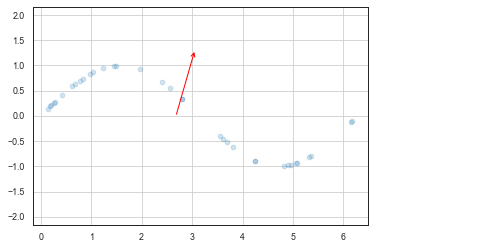

In [213]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=1,
                    shrinkA=0, shrinkB=0, color="red")
    ax.annotate('', v1, v0, arrowprops=arrowprops)

# plot data
plt.scatter(normal2[:, 0], normal2[:, 1], alpha=0.2)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    print(v)
    draw_vector(pca.mean_, pca.mean_ + v)
plt.yscale('linear')
plt.axis("equal")
plt.grid(True)

In [32]:
def id_est_comp(data):
    marg_dists = []
    for marg in data:
        marg_dists.append(get_dist(marg))
    n = len(marg_dists)
    psi = np.empty(shape=(n,n))
    print(psi.shape)
    for i in range(len(marg_dists)):
        for j in range(len(marg_dists)):
            val = marg_dists[i].expect((lambda x: marg_dists[j].pdf(x)))
            psi[i][j] = val
    u, s, v = svd(psi)
    print(s)
    return u, s

In [38]:
def id_est_comp(data):
    marg_dists = []
    for marg in data:
        marg_dists.append(get_dist(marg))
    n = len(marg_dists)
    psi = np.empty(shape=(n,n))
    print(psi.shape)
    for i in range(len(marg_dists)):
        for j in range(len(marg_dists)):
            val = marg_dists[i].expect((lambda x: marg_dists[j].pdf(x)))
            psi[i][j] = val
    u, s, v = svd(psi)
    print(s)
    return u, s, psi.diagonal()

In [26]:
u, s = id_est_comp(normal2.T)
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    ax.set_xlim(-20,20)
    ax.set_ylim(-20,20)
    arrowprops=dict(arrowstyle='->',
                    linewidth=1,
                    shrinkA=0, shrinkB=0, color="red")
    ax.annotate('', v1, v0, arrowprops=arrowprops)


# plot data
plt.scatter(normal2[:, 0], normal2[:, 1], alpha=0.2)
for length, vector in zip(s**(-1), u):
    v = vector * 3 * np.sqrt(length)
    print(v)
    draw_vector(pca.mean_, pca.mean_ + v)
plt.yscale('linear')
plt.axis("equal")
plt.grid(True)

NameError: name 'normal2' is not defined

In [44]:
curve = generate_kd_curve(2, noise=0.2).T

In [45]:
id_est(curve.T)

(2, 2)
i: 0, j: 0
0.13632672770700105
i: 0, j: 1
0.03938728766837372
i: 1, j: 0
0.1506227025002254
i: 1, j: 1
0.3604261450582854
[[0.13632673 0.03938729]
 [0.1506227  0.36042615]]
[0.4014324  0.10762235]
[2.49107946 9.29175044]


1.2680958206278854

(2, 2)
[0.38075836 0.11599452]
[0.72780248 2.52348031]
[ 8.28346246 -2.38905155]


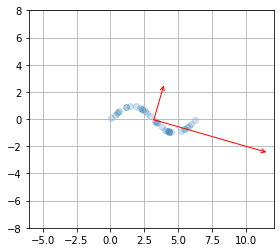

In [69]:
from sklearn.decomposition import PCA
import plotly.graph_objects as go
pca = PCA(n_components=2)
transformed = pca.fit_transform(curve)

u, s, ip = id_est_comp(curve.T)
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    ax.set_aspect("equal", "box")
    arrowprops=dict(arrowstyle='->',
                    linewidth=1,
                    shrinkA=0, shrinkB=0, color="red")
    ax.annotate('', v1, v0, arrowprops=arrowprops)


# plot data
plt.scatter(curve[:, 0], curve[:, 1], alpha=0.2)
for length, vector in zip(s**(-1), u):
    v = vector * length
    print(v)
    draw_vector(pca.mean_, pca.mean_ + v)
plt.yscale('linear')
plt.axis([-6, 12, -8, 8])
plt.grid(True)

[-3.3140165  1.0265291]
[0.05355294 0.17288876]


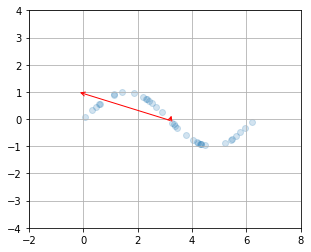

In [74]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    ax.set_aspect("equal", "box")
    arrowprops=dict(arrowstyle='->',
                    linewidth=1,
                    shrinkA=0, shrinkB=0, color="red")
    ax.annotate('', v1, v0, arrowprops=arrowprops)

# plot data
plt.scatter(curve[:, 0], curve[:, 1], alpha=0.2)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * length
    print(v)
    draw_vector(pca.mean_, pca.mean_ + v)
plt.yscale('linear')
plt.axis([-2, 8, -4, 4])
plt.grid(True)

In [12]:
def ip_est(data, scaling=True):

    if data.ndim > 1:
        d, n = data.shape
    else:
        d, n = 1, len(data)
        
    var = (n * (d + 2) / 4.)**(-1. / (d + 4)) * data.std()
    h = var*math.sqrt(2)

    total = 0
    for i in range(n):
        for j in range(i):
            diff = data[j] - data[i]
            if scaling:
                total += 1/(math.sqrt(2.*np.pi)*h) * math.exp(-(diff**2)/(2*h**2))
            else:
                total += math.exp(-(diff**2)/(2*h**2))
    total *= 2
    return 1/(n**2) * total

In [46]:
ip_est(curve.T[0])**(-1)

7.818852111305787

In [47]:
ip_est(curve.T[1])**(-1)

2.9493526555956744

In [82]:

n1 = np.random.normal(-2, 1, (500, 2))
n2 = np.random.normal(2, 1, (500, 2))
bimodal = np.concatenate([n1, n2])

In [83]:
fig = go.Figure(data=[go.Scatter(x=bimodal.T[0], y=bimodal.T[1],
                                   mode='markers')])
fig.show()

In [84]:
pca = PCA(n_components=2)
transformed = pca.fit_transform(bimodal)
fig = go.Figure(data=[go.Scatter(x=transformed.T[0], y=transformed.T[1],
                                   mode='markers')])
fig.show()

In [87]:
id_est(bimodal.T)

(2, 2)
i: 0, j: 0
0.1274620870443312
i: 0, j: 1
0.12702992918795605
i: 1, j: 0
0.12674425387363827
i: 1, j: 1
0.12689657521999714
[[0.12746209 0.12702993]
 [0.12674425 0.12689658]]
[0.25406682 0.000292  ]
[   3.93597247 3424.60163566]


1.0011493227199173

In [88]:
print(ip_est(bimodal.T[0]))
print(ip_est(bimodal.T[1]))

0.12700342492691477
0.12644238849312753


(2, 2)
[0.25396944 0.00038922]
[-5.55376757 -5.54139583]
[-5.56609094  5.57851781]


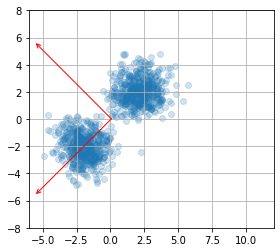

In [95]:
u, s, ip = id_est_comp(bimodal.T)
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    ax.set_aspect("equal", "box")
    arrowprops=dict(arrowstyle='->',
                    linewidth=1,
                    shrinkA=0, shrinkB=0, color="red")
    ax.annotate('', v1, v0, arrowprops=arrowprops)


# plot data
plt.scatter(bimodal[:, 0], bimodal[:, 1], alpha=0.2)
for length, vector in zip(ip**(-1), u):
    v = vector * length
    print(v)
    draw_vector(pca.mean_, pca.mean_ + v)
plt.yscale('linear')
plt.axis([-6, 12, -8, 8])
plt.grid(True)

[6.50627863 6.57263117]
[-0.69808684  0.69103946]


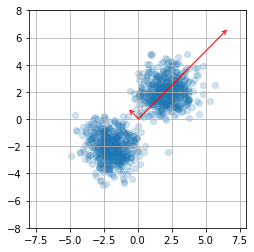

In [94]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    ax.set_aspect("equal", "box")
    arrowprops=dict(arrowstyle='->',
                    linewidth=1,
                    shrinkA=0, shrinkB=0, color="red")
    ax.annotate('', v1, v0, arrowprops=arrowprops)

# plot data
plt.scatter(bimodal[:, 0], bimodal[:, 1], alpha=0.2)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * length
    print(v)
    draw_vector(pca.mean_, pca.mean_ + v)
plt.yscale('linear')
plt.axis([-8, 8, -8, 8])
plt.grid(True)

In [113]:
d72 = np.vectorize(lambda n: generate_12_manifold(n=2500))
custom_run(2, 3, m=1, n=2500, title="72d manifold", dataset=d72)

estimating ID for 72d manifold
ID:  2
4.373396718308266


In [110]:
pca = PCA(n_components=72)
transformed = pca.fit_transform(d72(2500))

In [112]:
sum(pca.explained_variance_)/max(pca.explained_variance_)

19.223359731095794